# Métodos sem malha
Este trabaho contará com a implementação de 03 métodos sem malha para estruturas elásticas e viscoelásticas em estruturas bidimensionais submetidas a estado plano de tensão ou deformação. Os métodos a serem implementados serão o da Colocação, Galerkin e Petrov-Galerkin. Todos utilizarão o Método dos Mínimos Quadrados Móveis para interpolação.

## Dependências
A seguir encontram-se as bibliotecas utilizadas no presente trabalho.

In [1]:
%matplotlib notebook

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import pprint as pp

## Dados
Abaixo encontram-se os dados utilizados nos problemas abaixo.
 
  - interpolação: $z = 3+2x+5x^2+4xy$

In [2]:
# Dados da Interpolação:
interpol_data = [
    [-1,-1,10],
    [1,-1,6],
    [-1,0,6],
    [0,0,3],
    [1,0,10],
    [-1,1,2],
    [0,1,3],
    [1,1,14]
]
interpol_base = ["1","x","x**2","y","y**2","x*y"]; #Base quadrática
#interpol_base = ["1","x","y"]; #Babse Linear
#interpol_base = ["1","x","y","x**2,"x*y","y**2","x**3","(x**2)*y","x*(y**2)","y**3"];

In [3]:
# Dados Método Sem Malha
pde_base = ["1","x","x**2","y","y**2","x*y"]; #Base quadrática
pde_base_x = ["0","1","2*x","0","0","y"] #Derivada primeira da base em relação a x
pde_base_xx = ["0","0","2","0","0","0"] #Derivada segunda da base em relação a x
pde_base_y = ["0","0","0","1","2*y","x"] #Derivada primeira da base em relação a y
pde_base_yy = ["0","0","0","0","2","0"] #Derivada segunda da base em relação a y

#pde_base = ["1","x","y"]; #Base Linear
#pde_base = ["1","x","y","x**2,"x*y","y**2","x**3","(x**2)*y","x*(y**2)","y**3"];

k = 6
sizeix = 0 #Tamanho inicial do domínio em y
sizeiy = 0 #Tamanho inicial do domínio em x
sizex = 1 #tamanho do domínio em x
sizey = 1 #tamanho do domínio em y
pde_domain_count = (k-1)**2 #número de pontos no domínio
pde_contour_count = k*4 #número de pontos no contorno

count_left = [[sizeiy,sizey*y/k] for y in range(1,k+1)] #Pontos no contorno esquerdo
count_right = [[sizex,sizey*y/k] for y in range(1,k+1)] #Pontos no contorno direito
count_bottom = [[sizex*x/k,sizeix] for x in range(1,k+1)] #Pontos no contorno abaixo
count_top = [[sizex*x/k,sizey] for x in range(1,k+1)] #Pontos no contorno acima

domain = [[sizex*x/k,sizey*y/k] for x in range(1,k) for y in range(1,k)]

pde_data = domain + count_left + count_right + count_bottom + count_top


In [14]:
#Dados sobre a minha PDE e condições de contorno

pde_differential_x = { #Sobre minha equação diferencial
    'order': 2, #Ordem da minha PDE
    'var': 'x', #Variável utilizada
    'base1': pde_base_x,
    'base2': pde_base_xx
}

pde_differential_y = { #Sobre minha equação diferencial
    'order': 2, #Ordem da minha PDE
    'var': 'y', #Variável utilizada
    'base1': pde_base_y,
    'base2': pde_base_yy
}

#Objetos que representam as condições de contorno 

pde_contour_conditions = {
    'top': {
        'kind': 'dirichlet', #Caracteristicas do objeto top
        'value': 0
    },
    'bottom': {
        'kind': 'dirichlet',
        'value': 0
    },
    'left': {
        'kind': 'neumann',
        'order': 1,
        'var': 'x',
        'base1': pde_base_x,
        'base2': pde_base_xx,
        'value': 0
    },
    'right': {
        'kind': 'neumann',
        'order': 1,
        'var': 'x',
        'base1': pde_base_x,
        'base2': pde_base_xx,
        'value': 0
    }
}

#A função que define quando utilizar cada objeto
def pde_contour_class(p): #p = parametro para saber a cond
    if p[0] == sizeix:
        return 'left'
    elif p[0] == sizex:
        return 'right'
    elif p[1] == sizeiy:
        return 'bottom'
    elif p[1] == sizey:
        return 'top'
    else:
        return None
    
#Definir minha função se for contorno:

def pde_contour_func(p):
    clazz = pde_contour_class(p)
    cond = pde_contour_conditions[clazz]
    return cond['value']

def pde_domain_func(p):
    return np.exp(-((p[0]-.5)*(p[0]-.5) + (p[1]-.5)*(p[1]-.5))) #retorna a função que é dada no domínio 

def pde_func(p):
    clazz = pde_contour_class(p)
    if clazz == None:
        return pde_domain_func(p)
    else:
        return pde_contour_func(p)


## Definição Função Peso

Criar a função gaussiana com raio e Função Spline, verificando qual se comporta melhor na modelagem.

$\textbf{Função Gaussiana com raio:}$

$
w(\vec d) = 
\begin{cases}
\dfrac{{e^{-({\frac{||\vec d||}c})^2}} - {e^{-({\frac r c})^2}}}{1-{e^{-({\frac{r}c})^2}}}, \ d < r
\\\\
0, \ d > r
\end{cases}
$

$\textbf{Função Spline:}$

$
w(\vec d) = 
\begin{cases}
\ {1- 6{({\frac{||\vec d||}r})^2} + 8{({\frac{||\vec d||}r})^3} - 3{({\frac{||\vec d||}r})^4}}, \ d < r
\\\\
0, \ d > r
\end{cases}
$

$\textbf{Obs:}$ 
- dist: $\textbf{x} $ - $\textbf{x$_{j}$} $ = $\vec d $
    
- r: raio limite do subdominio (suporte)
    
    
 

In [5]:
def gaussian_with_radius (dist,r, derivate = None):
    c = 100
    exp1 = np.exp(-(la.norm(dist)/c)**2) #Exponencial 1
    exp2 = np.exp(-(r/c)**2) #Exponencial 2
    weight = (exp1 - exp2)/(1 - exp2)
    
    #Função Peso normal Gaussiana com raio:
    if not derivate:
        return weight if (la.norm(dist)<=r) else 0 
   
    #Derivadas dessa função peso:
    else:
        c1 = 1/(1 - exp2)
        
        if derivate['var']=='x':
            axis = dist[0]
        elif derivate['var']=='y':
            axis = dist[1]
        
        #Primeira derivada da função peso
        d1 = -2*c1*axis*exp1/(c**2)
     
        d2 = -2*c1*(c**2 - 2*axis**2)*exp1/(c**4) #Segunda derivada da função peso     
        return d1 if (derivate['order']==1) else d2


def spline (dist,r):
    div = la.norm(dist)/r
    weight = 1 - 6*(div**2)+8*(div**3)-3*((div**4))
    
    return weight if (la.norm(dist) <=r) else 0


fig = plt.figure("peso -gaussiana com raio")
xs = np.arange(-100,100,10)
ys = np.arange(-100,100,10)
X, Y = np.meshgrid(xs, ys)

zs = np.array([ gaussian_with_radius([x,y],80) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)


mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)


fig = plt.figure("peso -gaussiana com raio - primeira derivada")
xs = np.arange(-100,100,10)
ys = np.arange(-100,100,10)
X, Y = np.meshgrid(xs, ys)

zs = np.array([ gaussian_with_radius([x,y],80,{'order': 1,'var': 'x'}) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)


mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)

fig = plt.figure("peso -gaussiana com raio - segunda derivada")
xs = np.arange(-100,100,10)
ys = np.arange(-100,100,10)
X, Y = np.meshgrid(xs, ys)

zs = np.array([ gaussian_with_radius([x,y],80,{'order': 2,'var': 'x'}) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)


mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Matriz Peso $(W)$

In [6]:
def W (data,point,r, derivate = None): #data =  número de ptos, point = ponto analisado, r = raio mínimo
    W = []
    if not derivate:
        for index,row in enumerate(data):
            d2d = row[0:2] # (x,y)
            leftZeroes = np.zeros([1,index]) # 0 0 0 ... 0 } index vezes
            rightZeroes = np.zeros([1,len(data) - index - 1])
            weight = gaussian_with_radius(np.subtract(d2d,point),r)
            newRow = np.concatenate([leftZeroes,[[weight]],rightZeroes],axis=1)[0]
            W.append(newRow)
        return W
    else:
        for index,row in enumerate(data):
            d2d = row[0:2] # (x,y)
            leftZeroes = np.zeros([1,index]) # 0 0 0 ... 0 } index vezes
            rightZeroes = np.zeros([1,len(data) - index - 1])
            weight = gaussian_with_radius(np.subtract(d2d,point),r,derivate)
            newRow = np.concatenate([leftZeroes,[[weight]],rightZeroes],axis=1)[0]
            W.append(newRow)
        return W

## Matriz de Base $(P)$

In [7]:
def create_base(base,data):
    P = []
    for dat in data:
        row = []
        for b in base:
            [x,y] = dat[0:2]
            row.append(eval(b))
        P.append(row)
    return P

## Raio mínimo $(r)$
    Parâmetros:
 - `data`: conjunto de dados
 - `points`: pontos de referência
 - `m`: quantidade de pontos no suporte

In [8]:
def get_radius(data,point,m):
    distances = []
    for dat in data:
        dif = np.subtract(point,dat[0:2])
        dist = la.norm(dif)
        distances.append(dist)
    distances = sorted(distances);
    return distances[m+1]

## Coeficientes $\varphi_k(x)$
Coeficientes utilizados na interpolação linear
$$
\begin{aligned}
B(x) &= P^TW(x)\\
A(x) &= B(x)P = P^TW(x)P\\
\varphi^T(x)&=p^TA^{-1}(x)B(x)
\end{aligned}
$$

In [9]:
def coefficients(data,point,base,derivate = None):
    m = len(pde_base)
    r = get_radius(data,point,m)
    P = create_base(base,data)
    Pt = np.transpose(P)
    pt = create_base(base,[point])
   # ide = ideal(data,base,point,r)
    
    while True:
        B = Pt@W(data,point,r)
        A = B@P
        det = la.det(A)
        if(abs(det) < 1e-3):
            r*=1.1;
           # print(ide(data,base,point,r))
            continue
        if not derivate:
            return pt@la.inv(A)@B
        
        else:
            dptd_ = create_base(derivate['base1'],[point])
            dptd_2 = create_base(derivate['base2'],[point])
            dWd_ = W(data,point,r,{
                'order': 1,
                'var': derivate['var']
            })
            dAd_ = Pt@dWd_@P
            dBd_ = Pt@dWd_
            invA = la.inv(A)
            d2Wd_ = W(data,point,r,{
                'order': 2,
                'var': derivate['var']
            })
            d2Bd_2 = Pt@d2Wd_
            d2Ad_2 = d2Bd_2@P
            
            #Primeira Derivada
            
            d1 = dptd_@invA@B - pt@invA@dAd_@invA@B + pt@invA@dBd_
            
            #Segunda Derivada
            
            d2 = dptd_2@invA@B + np.array([[2]])@pt@invA@dAd_@invA@dAd_@invA@B - pt@invA@d2Ad_2@invA@B + pt@invA@d2Bd_2 - np.array([[2]])@dptd_@invA@dAd_@invA@B + np.array([[2]])@dptd_@invA@dBd_ - np.array([[2]])@pt@invA@dAd_@invA@dBd_
        
            if derivate['order'] == 1:
                return d1
            elif derivate['order'] == 2:
                return d2
            break

## Função de Interpolação $(ũ)$

In [10]:
def interpol(data,base,point):
    c = coefficients(data,point,base)
    u = np.array([z for x,y,z in data])
    
    return np.matmul(c,u)

## Teste de Interpolação

In [11]:
xs = [x for x,y,z in interpol_data]
ys = [y for x,y,z in interpol_data]
zs = [z for x,y,z in interpol_data]

fig = plt.figure("interpol - dados")

data_plot = fig.add_subplot(111, projection='3d')
data_plot.scatter(xs,ys,zs)

fig = plt.figure("interpol -aproximação")
xs = np.arange(0,1,0.1)
ys = np.arange(0,1,0.1)
X, Y = np.meshgrid(xs, ys)

zs = np.array([interpol(interpol_data,interpol_base,[x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)

mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Método da colocação
Sejam $x_1 \dots x_n$ $n$ pontos no domínio sujeitos a equação $\mathcal L u(x) = b(x)$ e $x_{n+1} \dots x_{n+m}$ $m$ pontos no contorno sujeitos as equações $\mathcal L_k c(x) = b_k(x)$


$$
\begin{aligned}
(\mathcal L \varphi)&*&\mathbf u &= &\mathbf b\\
\left[
\begin{matrix}
\mathcal L \varphi_1(x_1) & \dots & \mathcal L \varphi_n(x_1)& 0 &\dots & 0 \\
&\vdots&&&\vdots\\
\mathcal L \varphi_1(x_n)& \dots & \mathcal L \varphi_n(x_n) & 0 &\dots & 0 \\
0 & \dots & 0 &\mathcal L_1 c_1(x_{n+1})&\dots & \mathcal L_1 c_m(x_{n+1})\\
&\vdots&&&\vdots \\
0 & \dots & 0 &\mathcal L_m c_1(x_{n+m})&\dots & \mathcal L_m c_m(x_{n+m})
\end{matrix}
\right]&*
&\left[
\begin{matrix}
u_1\\ \vdots \\ u_n\\ u_{n+1} \\ \vdots \\ u_{n+m}
\end{matrix}
\right] &=
&\left[
\begin{matrix}
b(x_1) \\ \vdots \\ b(x_n) \\ b_1(x_{n+1}) \\ \vdots \\ b_m(x_{n+m})
\end{matrix}
\right]
\end{aligned}
$$

<IPython.core.display.Javascript object>


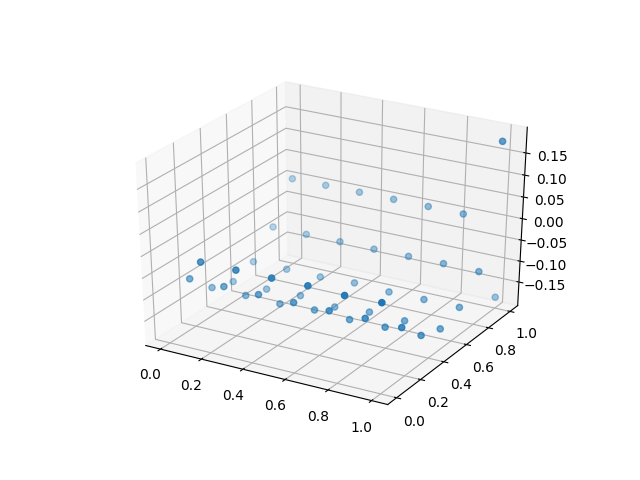

<IPython.core.display.Javascript object>


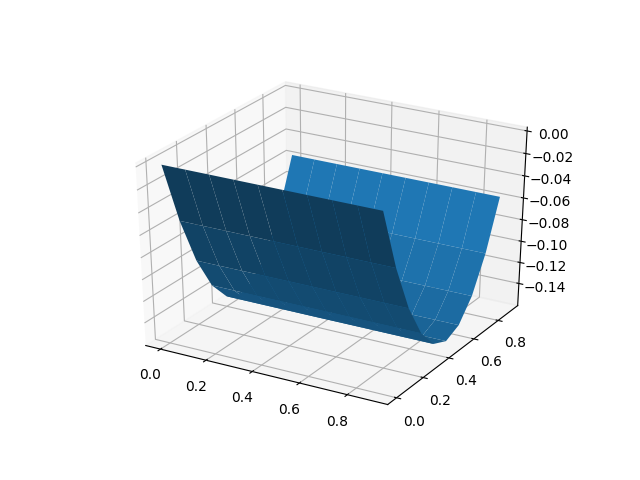

In [17]:
lphi = []

#Construção da matriz de coeficientes
for i in range(pde_domain_count + pde_contour_count): 
    point = pde_data[i]
    if i < pde_domain_count: #Dominio
        cx = coefficients(pde_data,point,pde_base, pde_differential_x)
        cy = coefficients(pde_data,point,pde_base, pde_differential_y)
        
        result = np.add(cx[0],cy[0])
        lphi.append(result)
    else: #Contorno
        clazz = pde_contour_class(point)
        cond = pde_contour_conditions[clazz]
        if cond['kind'] == 'dirichlet':
            c = coefficients(pde_data,point,pde_base)
            lphi.append(c[0])
            

        elif cond['kind'] == 'neumann':
            c = coefficients(pde_data,point,pde_base,cond)
            lphi.append(c[0])
           
bb = [pde_func(p) for p in pde_data]

answer = la.inv(lphi)@bb

xs = [x for x,y in pde_data]
ys = [y for x,y in pde_data]
zs = answer

fig = plt.figure("pde - dados")

data_plot = fig.add_subplot(111, projection='3d')
data_plot.scatter(xs,ys,zs)


fig = plt.figure("pde - aproximação")
xs = np.arange(0,1,0.1)
ys = np.arange(0,1,0.1)
X, Y = np.meshgrid(xs, ys)

cat_data = np.concatenate((np.array(pde_data),np.transpose([answer])),axis=1)
zs = np.array([ interpol(cat_data,pde_base,[x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z=zs.reshape(X.shape)

mesh_plot = fig.add_subplot(111, projection='3d')
mesh_plot.plot_surface(X,Y,Z)
